In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import pickle
import scipy.optimize as opt
import scipy
from budget_monte_carlo import *
import phase_noise #import procData, p0dict_638
from linear_response import build_Oseq, response_G13, isometry_haar_full
from linear_response_2photon import response_2photon, build_Oseq_2photon
import pandas as pd

In [2]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11


<h2>Configuration</h2>

In [8]:
atom_name = 'Cs'
n=50
l = 1
j = 3/2
mj = 3/2

atom_d = 2.5 #um
Omega_Rabi= 1*2*np.pi  #MHz
Bz = 10 #G
pulse_time= 7.65 #Omega_Rabi
resolution = 200 # number of phase steps in the pulse

w0_rydberg = 10 #um
lambda_rydberg = 0.319 #um

HF_split = 500*np.pi*2 # MHz
HF_split = None #if mj=1/2 split is from B-field

alpha_dc = 700 #MHz (V/cm)^-2
alpha_dc = None

T_atom = 15 #uK
trap_depth = 500 #uK
lambda_trap = 1.064 #um
w0_trap = 1.2 #um

edc_fluc = 10e-3 #V/cm
edc_zero = 0 #V/m

bdc_fluc = 10e-3 #G

num_samples =1000

phase_noise_csv = "638_20MHz-2-2-2026.csv"
RIN_csv_path = '319_Intensity_0.442VDC.csv' 
RIN_background_csv_path = 'UV_intensity_background.csv'
intensity_DC_V = 0.442

In [9]:
if atom_name == "Rb":
    atom = Rubidium()
elif atom_name == "Cs":
    atom = Caesium()
blockade_mrad = find_blockade_Mrad(atom_name, n, atom_d)
print('Blockade:', blockade_mrad/2/np.pi , 'MHz')
R_lifetime = atom.getStateLifetime(n=n,l=l,j=j,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
m_atom = atom.mass
if HF_split is None:
    HF_split = (atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=Bz/10000)-atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000))/hbar/1e6

Blockade: 7.547593190340064 MHz


<h2>Find optimized phase</h2>

In [10]:
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen.pulse_time,H_gen.resolution)
# fid_optimize(PhaseGuess, H_gen)
# H_gen.return_fidel
fid, global_phi = H_gen.return_fidel(phases=phase_guess, dt=dt)
print('Infidelity before optimizer:', 1-fid)
opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen))
phase_params = opt_out.x
# print(phase_params)
infid_TO_opti = opt_out.fun
print('Infidelity after optimizer:', infid_TO_opti) 
print('phase parameter', phase_params)
##%%


Infidelity before optimizer: 0.016712166206953927
Infidelity after optimizer: 0.004921314529286347
phase parameter [ 0.79716992  0.98552389 -0.94276014  0.01000603]


Text(0.5, 0, 'Time $(1/\\Omega)$')

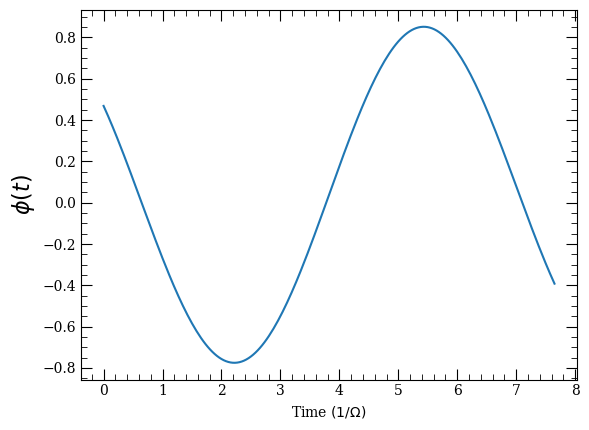

In [11]:
H_gen_the = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=10e9, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
time, phase, dt = phase_cosine_generate(*phase_params, H_gen.pulse_time,H_gen.resolution)
fid_TO_limit, global_phi = H_gen_the.return_fidel(phases=phase, dt=dt)
infid_TO = 1-fid_TO_limit
# print('TO gate infidel:'
fig, ax = plt.subplots()
ax.plot(time, phase)
ax.set_ylabel('$\phi(t)$', fontsize=16)
ax.set_xlabel('Time $(1/\Omega)$')

<h2>Budget_calculation</h2>

In [8]:
print('Gate theoretical infidelity:', infid_TO)
doppler_shift = 1/lambda_trap/1e-6*np.sqrt(kb*(T_atom*1e-6)/m_atom)
print('doppler shift:', doppler_shift/2/np.pi, 'Hz')


if alpha_dc is None:
    calc = StarkMap(atom)
    calc.defineBasis(n=n, l=1, j=1.5, mj=1.5, nMin=n-20, nMax=n+30, maxL=5, Bz=Bz/10000)
    calc.diagonalise(np.linspace(0,60,600))
    alpha_dc = calc.getPolarizability(debugOutput=True)
delta_edc = abs(-1/2*alpha_dc*1e6*((edc_zero+edc_fluc)**2-edc_zero**2))*2*np.pi 
print('Electric DC fluctuation:', delta_edc/2/np.pi, 'Hz')

delta_bdc = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=bdc_fluc/10000)/hbar
print('Magnetic DC fluctuation:', delta_bdc/2/np.pi, 'Hz')

total_shift = np.sqrt(delta_bdc**2+ delta_edc**2 + doppler_shift**2)
print('Total DC detuning fluctuation:', total_shift/2/np.pi, 'Hz')
detunings = total_shift/1e6/Omega_Rabi
print('delta/Ω:', detunings)
print('==============')
infids_s = []
for i in range(num_samples):
    d = sample_gaussian(detunings)
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=10e9, Delta1=d, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
    infids_s.append(1-fid)
infids_s = np.asarray(infids_s)
infids_detuning = np.mean(infids_s)-infid_TO
infids_detiuning_std = infids_s.std(ddof=1)

infids_bdc = delta_bdc**2/total_shift**2*infids_detuning
infids_edc = delta_edc**2/total_shift**2*infids_detuning
infids_doppler = doppler_shift**2/total_shift**2*infids_detuning

print(f'total error due to detuning: {infids_detuning} +/- {infids_detiuning_std}')
print('error due to E field: {}'.format(infids_edc))
print('error due to B field: {}'.format(infids_bdc))
print('error due to doppler: {}'.format(infids_doppler))
infids_s = []
infids_blockade = []
infids_rabi = []
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)
x1 = c1['x']
y1 = c1['y']
z1 = c1['z']
x2 = c2['x']
y2 = c2['y']
z2 = c2['z']
rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi

for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade = find_blockade_Mrad(atom_name, n, d)
    # total
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=10e9, Delta1=0, 
                     Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_s.append(1-fid)

    H_gen_block = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=10e9, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen_block.asym_return_fidel(phases=phase, dt=dt, omega1_scale=1, omega2_scale=1)
    infids_blockade.append(1-fid)

    H_gen_rabi = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=10e9, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen_rabi.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_rabi.append(1-fid)
infids_s = np.asarray(infids_s)
infids_motion = np.mean(infids_s) - infid_TO
infids_motion_std = infids_s.std(ddof=1)

infids_blockade = np.asarray(infids_blockade)
infids_motion_blockade = np.mean(infids_blockade) - infid_TO
infids_motion_blockade_std = infids_blockade.std(ddof=1)

infids_rabi = np.asarray(infids_rabi)
infids_motion_rabi = np.mean(infids_rabi) - infid_TO
infids_motion_rabi_std = infids_rabi.std(ddof=1)

print(f'total error due to atom motion: {infids_motion} +/- {infids_motion_std}')
print(f'total error due to atom motion(blockade): {infids_motion_blockade} +/- {infids_motion_blockade_std}')
print(f'total error due to atom motion(rabi): {infids_motion_rabi} +/- {infids_motion_rabi_std}')

# delta_mj = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=Bz/10000)/hbar/1e6 - \
# atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000)/hbar/1e6
leakage_mj  = (Omega_Rabi)**2/((Omega_Rabi)**2+HF_split**2)
print(f'eror due to leakage_mj:{leakage_mj}')

loss_decay = (2.95/(Omega_Rabi))/R_lifetime
print('error due to Rydberg decay:', loss_decay)



###
phase_noise_data = phase_noise.procData(phase_noise_csv, True, "638nm", range=20e6, p0=phase_noise.p0dict_638)
label = phase_noise_data[1][1]
vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)
# fig, ax = plt.subplots()
# ax.plot(vnoise_fs, vnoise_W, label=label)
# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_ylabel('Frequency PSD [Hz$^2$/Hz]')
# ax.set_xlabel('frequency [MHz]')
vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)
vnoise_contribution = []
# fs  = np.linspace(0,15,500)
# for f in fs:
S_haar = isometry_haar_full()   # D=4
o_f= build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=False)
for i in range(len(vnoise_fs)-1):
    deltaf = vnoise_fs[i+1]-vnoise_fs[i]
    If = response_G13(o_f, S_haar, vnoise_fs[i]*2*np.pi/Omega_Rabi, dt=dt)/Omega_Rabi**2
    vnoise_contribution.append(If*vnoise_W[i]*deltaf/1e6)
# plt.plot(f[:-1], vnoise_contribution)
vnoise_error = np.sum(vnoise_contribution)
print('error due to laser phase noise:', vnoise_error)

o_I = build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=True)

intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50*1e3) #dBm

bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 

# fig , ax = plt.subplots(ncols=2)
# ax[0].plot(fs_intensity, RIN_dbc)
# ax[0].plot(fs_intensity, RIN_db)
RIN_W = db_to_w(RIN_dbc)
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)
RIN_contribution = []
# fs  = np.linspace(0,15,500)
# for f in fs:
for i in range(len(fs_intensity)-2):
    deltaf = fs_intensity[i+2]-fs_intensity[i+1]
    Ii = response_G13(o_I, S_haar, fs_intensity[i+2]*2*np.pi/1e6/Omega_Rabi, dt=dt)
    RIN_contribution.append(Ii*RIN_W[i+2]*deltaf)
# plt.plot(fs[:-1], contribution)
RIN_error = np.sum(RIN_contribution)
print('error due to RIN:', RIN_error)


total_error = loss_decay + leakage_mj + infids_motion + infids_edc+infids_bdc + infids_doppler + RIN_error + vnoise_error+infid_TO
print('total error:', total_error)

Gate theoretical infidelity: 7.703633273514754e-07
doppler shift: 2645.5087349607716 Hz
finding original state for each electric field value
found  599
Scalar polarizability =  5040.781683022078  MHz cm^2 / V^2 
Electric DC fluctuation: 252039.08415110395 Hz
Magnetic DC fluctuation: 28009.017140649412 Hz
Total DC detuning fluctuation: 253604.42365498914 Hz
delta/Ω: 0.03170055295687364
total error due to detuning: 1.307199072170362e-06 +/- 1.919570217007517e-06
error due to E field: 1.2911118498941128e-06
error due to B field: 1.5944974173999913e-08
error due to doppler: 1.4224810224921556e-10
total error due to atom motion: 8.759516290457215e-05 +/- 0.00022230626974923168
total error due to atom motion(blockade): 8.339882038919255e-05 +/- 0.00021222455613712665
total error due to atom motion(rabi): 1.9441811623309714e-06 +/- 4.7213842435899e-06
eror due to leakage_mj:0.00025593448077292216
error due to Rydberg decay: 0.0003476752053037448
error due to laser phase noise: 4.1442967908728

In [9]:
Shiftout = 0.15508801095596728
V_intensity = 0.04393342753927566

In [13]:
optimized

{'Gate Design': np.float64(7.703633273514754e-07),
 'Laser Frequency': np.float64(4.144296790872857e-05),
 'Laser Intensity': np.float64(4.3933427539275665e-05),
 'E & B field': np.float64(1.3070568240681127e-06),
 'Motional': np.float64(8.75953051526744e-05),
 'Decay': np.float64(0.0003476752053037448),
 'Leakage $m_j=1/2$': 0.00025593448077292216,
 'Scattering': 0}

(5e-07, 0.3)

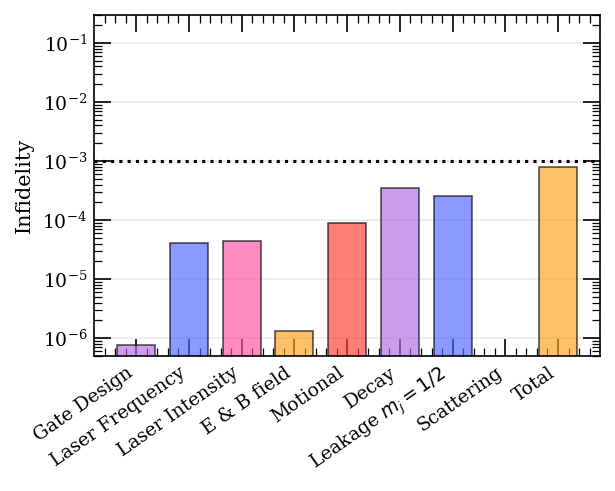

In [12]:
Shiftout = 0.05
labels = ("Gate Design", "Laser Frequency", "Laser Intensity", "E & B field", "Motional", "Decay", "Leakage $m_j=1/2$", "Total")
optimized = {
    # keep baseline values for things you did NOT change
    "Gate Design": infid_TO,
    "Laser Frequency": vnoise_error,
    "Laser Intensity": RIN_error,
    "E & B field": infids_edc + infids_bdc,
    "Motional": infids_motion + infids_doppler,
    "Decay": loss_decay,
    "Leakage $m_j=1/2$": leakage_mj,
    "Scattering": 0
}
baseline = {
    'Gate Design':  infid_TO,
 'Laser Frequency': vnoise_error,
 "Laser Intensity": RIN_error,
 "E & B field": infids_edc+infids_bdc,
 "Motional": infids_motion+infids_doppler,
 "Decay": loss_decay ,
 "Leakage $m_j=1/2$":Shiftout
}
# baseline["Total"]  = sum(baseline[k] for k in labels if k != "Total")
# optimized["Total"] = sum(optimized[k] for k in labels if k != "Total")
experiment = None


fig, ax = plot_error_budget(
    optimized,          # dict: {"Decay": val, "Frequency": val, ...} in absolute infidelity units (e.g. 1e-3)
    component_err=None,  # dict: {"Decay": std, ...} same units; optional
    experiment=experiment,     # float, experimental infidelity (same units); optional
    experiment_label=None,  # str label in the plot; optional
    omega_label=False,#r"$\Omega = 2\pi \times$" + " {:.2f}MHz".format(Omega_Rabi/2/np.pi),
    title=None,
    savepath=None,
)
ax.set_yscale('log')
ax.axhline(1e-3, c='k', linestyle=':')
ax.set_ylim([5e-7,3e-1])
# fig.savefig('50p_gate.pdf')

(5e-07, 0.15)

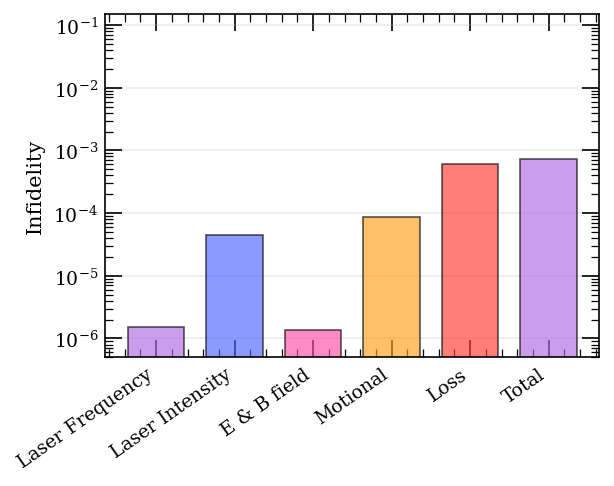

In [49]:
components = {'Laser Frequency': vnoise_error,
 "Laser Intensity": RIN_error,
 "E & B field": infids_edc+infids_bdc,
 "Motional": infids_motion+infids_doppler,
 "Loss": loss_decay +leakage_mj
}
experiment = None
fig, ax = plot_error_budget(
    components,          # dict: {"Decay": val, "Frequency": val, ...} in absolute infidelity units (e.g. 1e-3)
    component_err=None,  # dict: {"Decay": std, ...} same units; optional
    experiment=experiment,     # float, experimental infidelity (same units); optional
    experiment_label=None,  # str label in the plot; optional
    omega_label=False,#r"$\Omega = 2\pi \times$" + " {:.2f}MHz".format(Omega_Rabi/2/np.pi),
    title=None,
    savepath=None,
)
ax.set_ylim([5e-7,1.5e-1])
# fig.savefig('60p_initial_result.pdf')

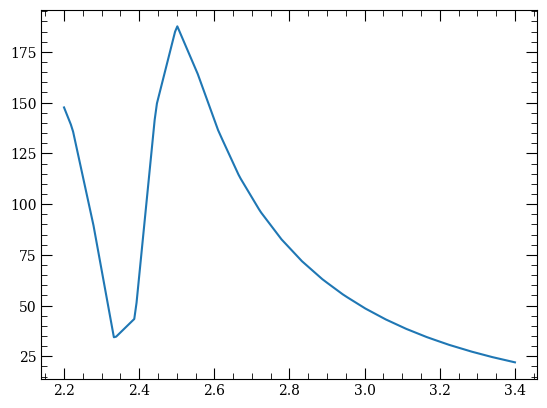

In [10]:
x = np.linspace(2.2, 3.4, 200)
blockade = [find_blockade_Mrad(atom_name, 65, y)/2/np.pi for y in x]
plt.plot(x,blockade)

(array([ 11.,  17.,  50.,  95., 119., 179., 165., 129.,  95.,  71.,  38.,
         16.,  11.,   2.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([2.26613676, 2.2912035 , 2.31627024, 2.34133697, 2.36640371,
        2.39147045, 2.41653719, 2.44160392, 2.46667066, 2.4917374 ,
        2.51680414, 2.54187087, 2.56693761, 2.59200435, 2.61707109,
        2.64213782, 2.66720456, 2.6922713 , 2.71733803, 2.74240477,
        2.76747151]),
 <BarContainer object of 20 artists>)

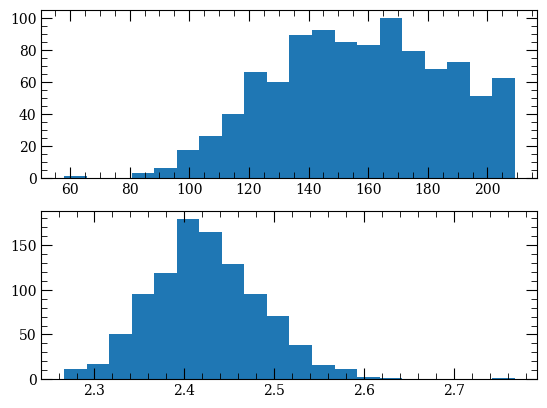

In [11]:
blockade = []
for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade.append(find_blockade_Mrad(atom_name, n, d)/2/np.pi)
fig, ax = plt.subplots(nrows=2)
ax[0].hist(blockade, bins=20)
ax[1].hist(ds, bins=20)

<h2> Budget Scan</h2>

In [12]:
phase_noise_data = phase_noise.procData(phase_noise_csv, True, "638nm", range=20e6, p0=phase_noise.p0dict_638)
label = phase_noise_data[1][1]
vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)

print('fitted frequency noise')
vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)


intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50*1e3) #dBm

bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 

RIN_W = db_to_w(RIN_dbc)
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)


## Linear Response ####
S_haar = isometry_haar_full()   # D=4
o_f= build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=False)
o_I = build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=True)
TO_1 = []
TO_2 = []
v_1photon = []
v_2photon = []
RIN_1photon = []
RIN_2photon = []
decay_1photon = []
decay_2photon = []
infids_motion1 = []
infids_motion2 = []
leakage1 = []
leakage2 = []
scattering1 = []
scattering2 = []
f_Rabis = np.linspace(0.1,2,50)
Omega_Rabis = 2*np.pi*f_Rabis
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)

for Omega_Rabi in Omega_Rabis:
    print('Omega:', Omega_Rabi/2/np.pi)
    H_gen1 = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
    time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen1.pulse_time,H_gen1.resolution)
    # fid_optimize(PhaseGuess, H_gen)
    # H_gen.return_fidel
    fid1, global_phi = H_gen1.return_fidel(phases=phase_guess, dt=dt)
    # print('Infidelity before optimizer:', 1-fid1)
    opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen1))
    phase_params1 = opt_out.x
    # print(phase_params)
    infid_TO_theory = opt_out.fun
    # print('Infidelity after optimizer:', infid_TO_theory) 
    # print('phase parameter', phase_params1)
    H_gen1 = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=1e10, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=1e10, pulse_time=pulse_time)
    time, phase1, dt = phase_cosine_generate(*phase_params1, H_gen1.pulse_time,H_gen1.resolution)
    fid1, global_phi = H_gen1.return_fidel(phases=phase1, dt=dt)
    infid_TO1 = 1-fid1
    # print(infid_TO1)
    TO_1.append(infid_TO1)
    


    vnoise1_contribution = []
    for i in range(len(vnoise_fs)-1):
        deltaf = vnoise_fs[i+1]-vnoise_fs[i]
        #
        If_1 = response_G13(o_f, S_haar, vnoise_fs[i]*2*np.pi/Omega_Rabi, dt=dt)/Omega_Rabi**2
        vnoise1_contribution.append(If_1*vnoise_W[i]*deltaf/1e6)

    v_1photon.append(np.sum(vnoise1_contribution))
    
    Inoise1_contribution = []
    for i in range(len(fs_intensity)-2):
        deltaf = fs_intensity[i+2]-fs_intensity[i+1]
        Ii = response_G13(o_I, S_haar, fs_intensity[i+2]*2*np.pi/1e6/Omega_Rabi, dt=dt)
        Inoise1_contribution.append(Ii*RIN_W[i+2]*deltaf)
    RIN_1photon.append(np.sum(Inoise1_contribution))

    decay_1photon.append((2.95/(Omega_Rabi))/R_lifetime)
    
    infids_s1 = []
    for d in ds:
        blockade1 = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade1, r_lifetime=1e10, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=1e10, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase1, dt=dt, omega1_scale=1, omega2_scale=1)
        infids_s1.append(1-fid)

    infids_s1 = np.asarray(infids_s1)
    infids_motion1.append(np.mean(infids_s1) - infid_TO1)

    leakage1.append((Omega_Rabi)**2/((Omega_Rabi)**2+HF_split**2))

    scattering1.append(0)

fitted frequency noise
Omega: 0.1
Omega: 0.13877551020408163
Omega: 0.17755102040816328
Omega: 0.2163265306122449
Omega: 0.25510204081632654
Omega: 0.29387755102040813
Omega: 0.3326530612244898
Omega: 0.37142857142857144
Omega: 0.4102040816326531
Omega: 0.44897959183673475
Omega: 0.4877551020408163
Omega: 0.5265306122448979
Omega: 0.5653061224489796
Omega: 0.6040816326530613
Omega: 0.6428571428571429
Omega: 0.6816326530612244
Omega: 0.720408163265306
Omega: 0.7591836734693878
Omega: 0.7979591836734694
Omega: 0.836734693877551
Omega: 0.8755102040816326
Omega: 0.9142857142857143
Omega: 0.9530612244897959
Omega: 0.9918367346938776
Omega: 1.0306122448979593
Omega: 1.0693877551020408
Omega: 1.1081632653061226
Omega: 1.146938775510204
Omega: 1.1857142857142857
Omega: 1.2244897959183674
Omega: 1.263265306122449
Omega: 1.3020408163265307
Omega: 1.3408163265306123
Omega: 1.379591836734694
Omega: 1.4183673469387756
Omega: 1.4571428571428575
Omega: 1.495918367346939
Omega: 1.5346938775510206
Omeg

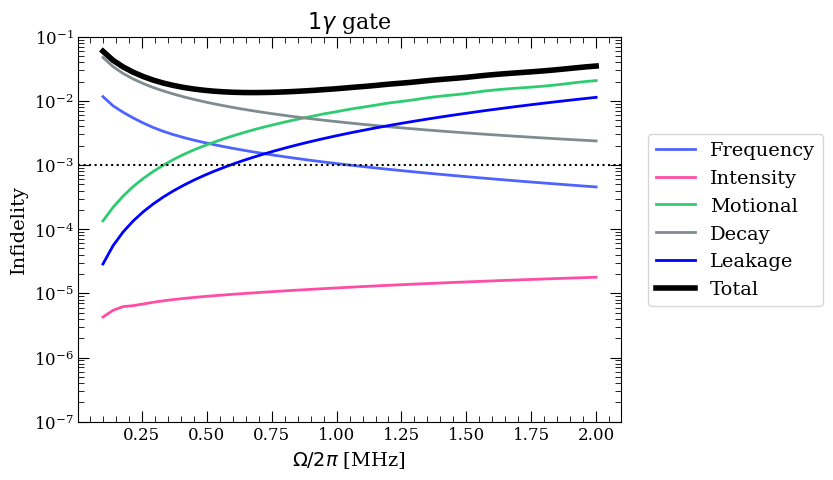

In [19]:
v_1photon = np.array(v_1photon)
RIN_1photon = np.array(RIN_1photon)
infids_motion1 = np.array(infids_motion1)
decay_1photon = np.array(decay_1photon)
leakage1 = np.array(leakage1)
scattering2 = np.array(scattering2)
sum_1photon = v_1photon+ RIN_1photon+infids_motion1+decay_1photon+leakage1

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(f_Rabis, v_1photon, c="#4e63ff", label='Frequency', linewidth=2)
ax.plot(f_Rabis, RIN_1photon, c="#ff4da6", label='Intensity', linewidth=2)
ax.plot(f_Rabis, infids_motion1, c="#2ecc71", label='Motional', linewidth=2)
ax.plot(f_Rabis, decay_1photon, c="#7f8c8d", label='Decay', linewidth=2)
# ax.plot(f_Rabis, scattering1, c='red', label='Scattering', linewidth=2)
ax.plot(f_Rabis, leakage1, c='blue', label='Leakage', linewidth=2)
ax.plot(f_Rabis, sum_1photon, c="k", label='Total', linewidth=4)
ax.axhline(1e-3, c='k', linestyle=":")
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_xlabel("$\Omega/ 2\pi$ [MHz] ", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_yscale('log')
ax.set_title('$1 \gamma$ gate', fontsize=16)
ax.set_ylim([1e-7, 1e-1])
ax.legend(loc=(1.05,0.3),fontsize=14)

<h2>Shot-to-shot detuning</h2>

In [12]:
deltas = np.linspace(0,0.1, 100)
deltas *= Omega_Rabi
infids_mean = []
infids_std  = []
for delta in deltas:
    infids_s = []
    for i in range(num_samples):
        d = sample_gaussian(delta)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

KeyboardInterrupt: 

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fractional_delta = deltas/Omega_Rabi
fig, ax = plt.subplots()
ax.plot(fractional_delta, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    fractional_delta,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Delta_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)
# fig.show()
# ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=2)

ax[0].hist(params, density=True)
ax[1].hist(infids, density= True)
print(np.mean(params))
print(np.mean(infids))

<h2>shot-to-shot Blockade</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    distances = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )[0]
    for d in distances:
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>shot-to-shot Intensity</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    d, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2 in zip(rabis1, rabis2):
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

In [ ]:
delta_omegas = np.linspace(0,0.1, 100)
infids_mean = []
infids_std  = []
for delta_omega in delta_omegas:
    infids_s = []
    for i in range(num_samples):
        omega_scaled = sample_gaussian(delta_omega)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt, omega_scale=(1-omega_scaled))
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(delta_omegas, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    delta_omegas,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Omega_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>Atom motion</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []

    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    ds, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

<h2>Laser noise</h2>

In [249]:
p0dict={'td': np.float64(1.9624461382089483e-05),
 'noise_floor': np.float64(4.190306965553739e-08),
 'h0': np.float64(4.335751591110533),
 'bumps': [{'f': np.float64(7338.21186586379),
   's': np.float64(325.179865705531),
   'h': np.float64(5.51932122527209)},
  {'f': np.float64(47048.79788982831),
   's': np.float64(4998.453289274678),
   'h': np.float64(112.00515592903649)},
  {'f': np.float64(27597.73202840252),
   's': np.float64(4336.3812372455795),
   'h': np.float64(10.230075439193143)},
  {'f': np.float64(118470.34208552839),
   's': np.float64(431.7300563424476),
   'h': np.float64(4220.051851121222)},
  {'f': np.float64(139795.45629525647),
   's': np.float64(179.34227070652142),
   'h': np.float64(14.870273061321923)},
  {'f': np.float64(237009.4335206111),
   's': np.float64(442.7742698819919),
   'h': np.float64(7816.583611630677)},
  {'f': np.float64(559957.2290628441),
   's': np.float64(3155477.1407008735),
   'h': np.float64(49.843310393019046)},
  {'f': np.float64(234194.58582077266),
   's': np.float64(-83348.90394572225),
   'h': np.float64(38.70444113759951)},
  {'f': np.float64(461771.6326412626),
   's': np.float64(-25278.167488921445),
   'h': np.float64(-50.48548182269121)}]}


sp: 40.52871643882268, sig: 209.9719979208283


(0.0, 100000.0)

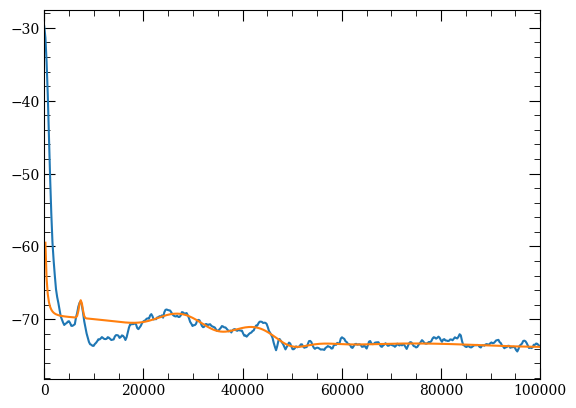

In [247]:
# phase_noise_csv = '638_20MHz-2-2-2026.csv' 
# data= phase_noise.readData(phase_noise_csv)
# pointdata = phase_noise.makeRelHetData(data)
# pointdata = phase_noise.dBToR(pointdata)
# pointdata = phase_noise.normalizePower(pointdata)
# peakopt = phase_noise.fitPeak(pointdata, bw=1e3, verbose=True)
# pnorm = peakopt[1]*4/(3*np.pi**4)
# pointdata = phase_noise.simpleGainTransfer(pointdata, gain=1/pnorm)
# pointdata = phase_noise.RTodB(pointdata)
# fit_popt = phase_noise.fitNoise(pointdata, phase_noise.test_Si_log, p0=p0dict, theoretical=False, verbose=False)

# vnoise_fs = []
# vnoise_W = []
# for d in pointdata:
#     if d[0] >=0:
#         vnoise_fs.append(d[0])
#         vnoise_W.append(d[1])
# vnoise_fs = np.array(vnoise_fs)
# fitted = phase_noise.test_Si_log(vnoise_fs, *phase_noise.p0dict_to_p0array(fit_popt))
# plt.plot(vnoise_fs,vnoise_W)
# plt.plot(vnoise_fs,fitted)
# plt.xlim([0,0.1e6])
# # fig2, ax2 = plt.subplots()
# # ax2.plot(fs_f, f_w_c, label=label)
# # ax2.set_yscale('log')
# # # ax.set_xscale('log')
# # ax2.set_ylabel('Frequency PSD [Hz$^2$/Hz]', fontsize=14)
# # ax2.set_xlabel('frequency [MHz]', fontsize=14)
# # ax2.set_xlim([99e6,100e6])
# # ax2.set_ylim([10e-14,1e-7])

# # intensity_noise_csv = pd.read_csv(phase_noise_csv, header=None)
# # fs_intensity = intensity_noise_csv[0]
# # RIN_db = intensity_noise_csv[1]
# # plt.plot(fs_intensity,RIN_db)
# # plt.xlim([98e6,102e6])

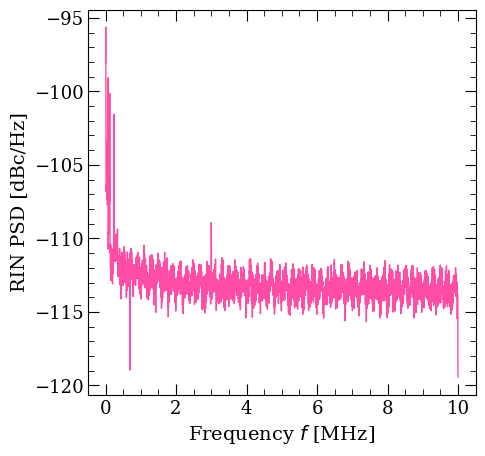

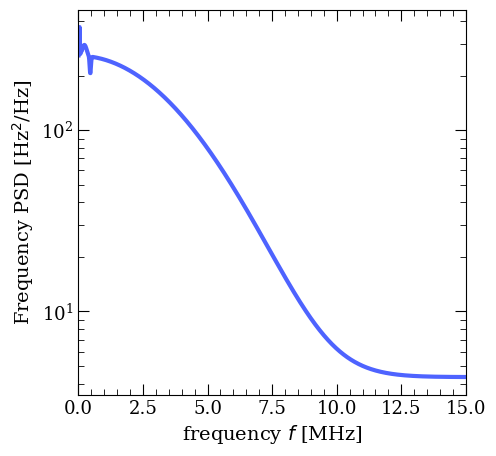

In [29]:
intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50*1e3) #dBm
bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz)
fig , ax = plt.subplots( figsize=(5,5))
ax.plot(fs_intensity[1:-1]/1e6, RIN_dbc[1:-1], c="#ff4da6", linewidth=1) 
ax.set_ylabel('RIN PSD [dBc/Hz]', fontsize=14)
ax.set_xlabel('Frequency $f$ [MHz]', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
fig.savefig('IntensityPSD_2Feb26.pdf', bbox_inches='tight')

phase_noise_csv = '638_20MHz-2-2-2026.csv' 
phase_noise_data = phase_noise.procData(phase_noise_csv, True, "638nm", range=20e6, p0=phase_noise.p0dict_638)

vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)
fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.plot(vnoise_fs, vnoise_W, c="#4e63ff", linewidth=3, label=label)
ax2.set_yscale('log')
# ax.set_xscale('log')
ax2.set_ylabel('Frequency PSD [Hz$^2$/Hz]', fontsize=14)
ax2.set_xlabel('frequency $f$ [MHz]', fontsize=14)
ax2.tick_params(axis='both', labelsize=13)
ax2.set_xlim([0,15])
fig2.savefig('fitted_frequencyPSD_2Feb26.pdf', bbox_inches='tight')
# ax2.set_ylim([10e-14,1e-7])

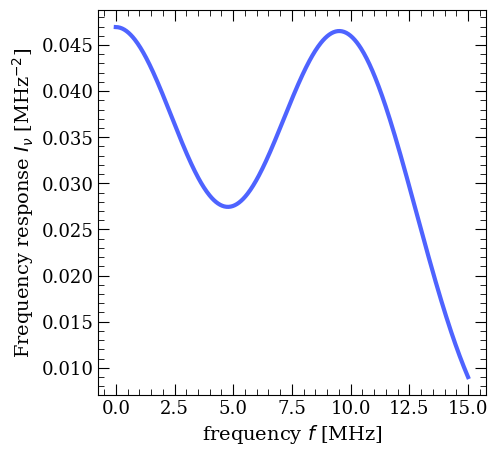

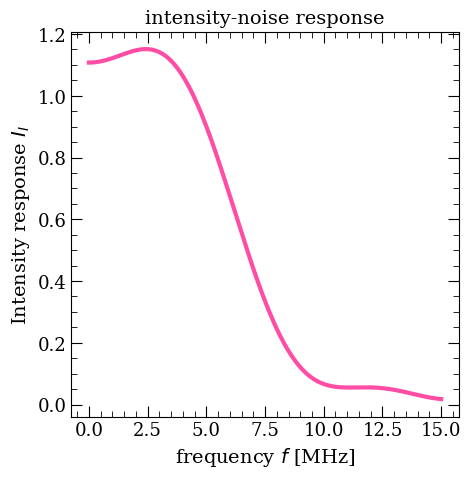

In [28]:
S_haar = isometry_haar_full()   # D=4
omegas = np.linspace(0,15,501)
o_f= build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=False)
I_nu_haar = np.array([response_G13(o_f, S_haar, omega*2*np.pi/Omega_Rabi, dt=dt) for omega in omegas])
I_nu_haar /= Omega_Rabi**2
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(omegas, I_nu_haar, c='#4e63ff', linewidth=3, label="Haar")
ax.set_xlabel(r"frequency $f$ [MHz]", fontsize=14)
ax.set_ylabel(r"Frequency response $I_\nu$ [MHz$^{-2}$]", fontsize=14)
ax.tick_params(axis='both', labelsize=13)
# ax.set_title("Frequency-noise response", fontsize=14)
fig.savefig('frequency_response.pdf', bbox_inches='tight')

o_I = build_Oseq(phases=phase, dt=dt, B=blockade_mrad, is_intensity=True)
I_inten_haar = np.array([response_G13(o_I, S_haar, omega*2*np.pi/Omega_Rabi, dt=dt) for omega in omegas])
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(omegas, I_inten_haar, c="#ff4da6", linewidth=3, label="O_I")
ax1.set_xlabel(r"frequency $f$ [MHz]", fontsize=14)
ax1.set_ylabel(r"Intensity response $I_I$", fontsize=14)
ax1.set_title("intensity-noise response", fontsize=14)
ax1.tick_params(axis='both', labelsize=13)
fig1.savefig('Intensity_response.pdf', bbox_inches='tight')

<h2>Read infdel</h2>

In [ ]:
result = np.load('results/infid_raw.npz')

In [ ]:
print(result['x_detuning'])

<h2>Laser noise</h2>

<h2>Stark shift</h2>

In [ ]:
inter_detuning = 5e3*2*np.pi #MHz
Omega1 = np.sqrt(Omega_Rabi*inter_detuning)
omega_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
omega_photon1 += inter_detuning/2/np.pi

d_blue = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e
d_red = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_g_gen = DynamicPolarizability(atom, n=6, l=0, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_g = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=7, l=1, j=1/2, s=0.5)
alpha_e_gen.defineBasis(6, 9)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=60, l=0, j=1/2, s=0.5)
alpha_e_gen.defineBasis(7, 75)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

In [ ]:
alpha_g